<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Processing%20Sequences%20Using%20RNNs%20and%20CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 22 17:40:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Processing Sequences Using RNNs and CNNs

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a time series. In the first two examples there is a single value per time step, so these are univariate time series, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a multivariate time series. A typical task is to predict future values, which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called imputation.

## Generating Data

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)
#     return series

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


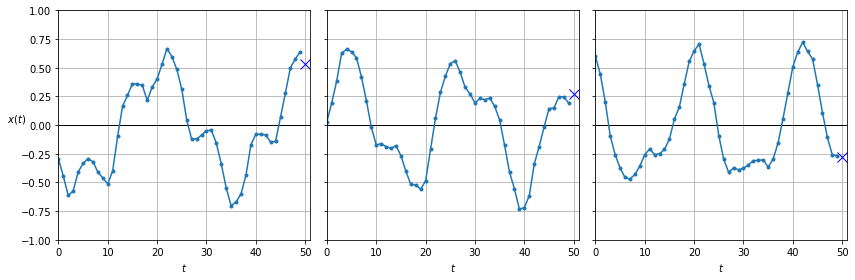

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.tight_layout()
plt.show()

## Computing Some Baselines

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform.


Naive predictions (just predict the last observed value):

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020416105

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
keras.backend.clear_session()

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50,1]),
    keras.layers.Dense(1)
])

In [10]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0695 - val_loss: 0.0308
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0145
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0089
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0042

In [11]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0035


0.003532787086442113

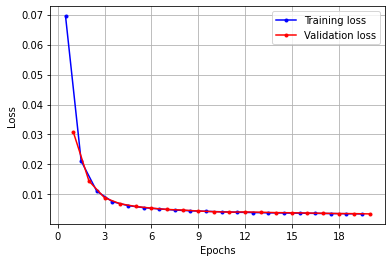

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Implementing a Simple RNN

In [13]:
keras.backend.clear_session()

In [14]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 33ms/step - loss: 0.6748 - val_loss: 0.5277
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.3907 - val_loss: 0.3146
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.2993 - val_loss: 0.2650
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.2512 - val_loss: 0.2221
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.2090 - val_loss: 0.1876
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1717 - val_loss: 0.1566
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1464 - val_loss: 0.1438
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1392 - val_loss: 0.1417
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1395 - val_loss: 0.1467
Epoch 10/20
219/219 [==============================] - 7s 32ms/step - loss: 0.1381 - val_lo

In [15]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.1372


0.13721401989459991

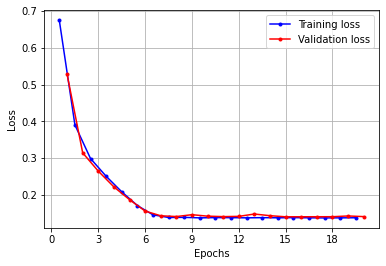

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [17]:
keras.backend.clear_session()

In [18]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [19]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 95ms/step - loss: 0.0343 - val_loss: 0.0057
Epoch 2/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 20s 91ms/step - loss: 0.003

In [20]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 10ms/step - loss: 0.0032


0.003191437106579542

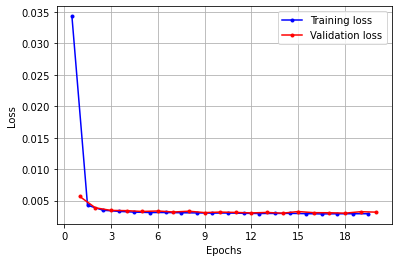

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [22]:
keras.backend.clear_session()

In [23]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [24]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0309 - val_loss: 0.0082
Epoch 2/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 3/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 13s 60ms/step - loss: 0.002

In [25]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0025


0.0025107134133577347

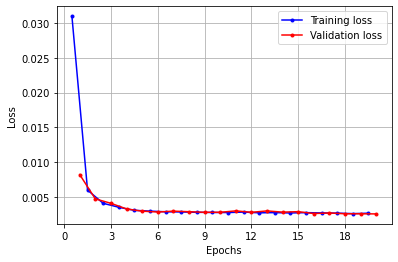

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Forecasting Several Steps Ahead

In [27]:
np.random.seed(42)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend()

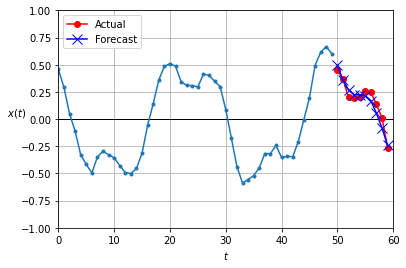

In [29]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [30]:
keras.backend.clear_session()

In [31]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [33]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0504 - val_loss: 0.0280
Epoch 2/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0237 - val_loss: 0.0180
Epoch 3/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0168 - val_loss: 0.0138
Epoch 4/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0133 - val_loss: 0.0110
Epoch 5/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 6/20
219/219 [==============================] - 13s 62ms/step - loss: 0.0109 - val_loss: 0.0124
Epoch 7/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 8/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 9/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 10/20
219/219 [==============================] - 13s 60ms/step - loss: 0.009

In [34]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0089


0.008948233909904957

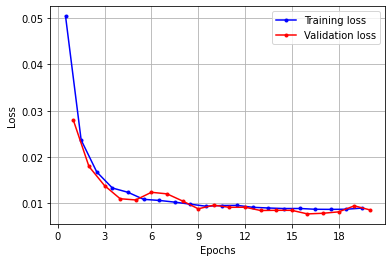

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [36]:
Y_pred = model.predict(X_new)

In [37]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

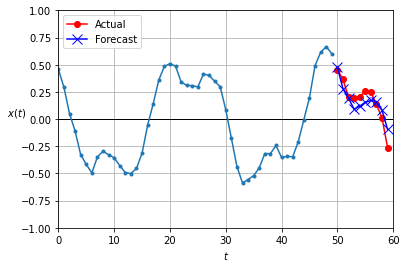

In [38]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [39]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead : step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]

It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between X_train and Y_train). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a causal model.

To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.

In [40]:
keras.backend.clear_session()

In [41]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [42]:
model.compile(loss = 'mse', optimizer = 'nadam', metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 14s 65ms/step - loss: 0.1045 - last_time_step_mse: 0.0552 - val_loss: 0.0246 - val_last_time_step_mse: 0.0175
Epoch 2/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0214 - last_time_step_mse: 0.0193 - val_loss: 0.0119 - val_last_time_step_mse: 0.0161
Epoch 3/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0046 - last_time_step_mse: 0.0058 - val_loss: 0.0026 - val_last_time_step_mse: 0.0042
Epoch 4/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0024 - last_time_step_mse: 0.0032 - val_loss: 0.0033 - val_last_time_step_mse: 0.0019
Epoch 5/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0018 - last_time_step_mse: 0.0025 - val_loss: 0.0015 - val_last_time_step_mse: 0.0026
Epoch 6/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0017 - last_time_step_mse: 0.0024 - val_loss: 0.0039 - val_last_time_step_mse: 0.0023
Epoch 7/20
219/2

In [43]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 4.9944e-04 - last_time_step_mse: 6.3864e-04


[0.0004994429764337838, 0.0006386360037140548]

In [44]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

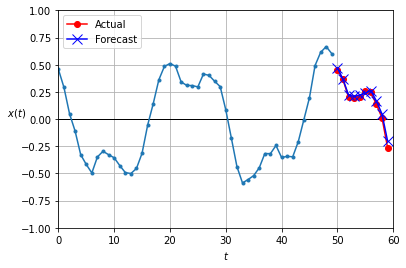

In [45]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNN with Batch Norm

In [46]:
keras.backend.clear_session()

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None,1]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 14s 65ms/step - loss: 0.2919 - last_time_step_mse: 0.2247 - val_loss: 0.1656 - val_last_time_step_mse: 0.1127
Epoch 2/20
219/219 [==============================] - 14s 63ms/step - loss: 0.1296 - last_time_step_mse: 0.0746 - val_loss: 0.0532 - val_last_time_step_mse: 0.0767
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0192 - last_time_step_mse: 0.0245 - val_loss: 0.0157 - val_last_time_step_mse: 0.0328
Epoch 4/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0096 - last_time_step_mse: 0.0124 - val_loss: 0.0084 - val_last_time_step_mse: 0.0110
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0070 - last_time_step_mse: 0.0093 - val_loss: 0.0063 - val_last_time_step_mse: 0.0078
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0054 - last_time_step_mse: 0.0073 - val_loss: 0.0051 - val_last_time_step_mse: 0.0064
Epoch 7/20
219/2

## Deep RNNs with Layer Norm

In [48]:
keras.backend.clear_session()

In [49]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 34s 154ms/step - loss: 0.2020 - last_time_step_mse: 0.1286 - val_loss: 0.1442 - val_last_time_step_mse: 0.0764
Epoch 2/20
219/219 [==============================] - 34s 154ms/step - loss: 0.0987 - last_time_step_mse: 0.0607 - val_loss: 0.0160 - val_last_time_step_mse: 0.0164
Epoch 3/20
219/219 [==============================] - 34s 155ms/step - loss: 0.0109 - last_time_step_mse: 0.0097 - val_loss: 0.0079 - val_last_time_step_mse: 0.0067
Epoch 4/20
219/219 [==============================] - 34s 157ms/step - loss: 0.0063 - last_time_step_mse: 0.0061 - val_loss: 0.0051 - val_last_time_step_mse: 0.0056
Epoch 5/20
219/219 [==============================] - 33s 151ms/step - loss: 0.0046 - last_time_step_mse: 0.0053 - val_loss: 0.0041 - val_last_time_step_mse: 0.0050
Epoch 6/20
219/219 [==============================] - 33s 150ms/step - loss: 0.0039 - last_time_step_mse: 0.0051 - val_loss: 0.0036 - val_last_time_step_mse: 0.0053
Epoch 7/20

## LSTMs

In [51]:
keras.backend.clear_session()

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape = [None,1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train , epochs = 20, validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0947 - last_time_step_mse: 0.0434 - val_loss: 0.0244 - val_last_time_step_mse: 0.0138
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0210 - last_time_step_mse: 0.0144 - val_loss: 0.0189 - val_last_time_step_mse: 0.0149
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0169 - last_time_step_mse: 0.0144 - val_loss: 0.0136 - val_last_time_step_mse: 0.0131
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0069 - last_time_step_mse: 0.0101 - val_loss: 0.0031 - val_last_time_step_mse: 0.0052
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0025 - last_time_step_mse: 0.0035 - val_loss: 0.0021 - val_last_time_step_mse: 0.0020
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0019 - last_time_step_mse: 0.0016 - val_loss: 0.0017 - val_last_time_step_mse: 0.0013
Epoch 7/20
219/219 [=======

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 5.2608e-04 - last_time_step_mse: 1.5948e-04


[0.0005260783946141601, 0.00015948005602695048]

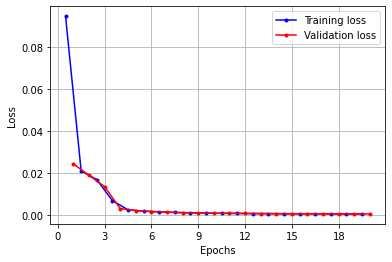

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

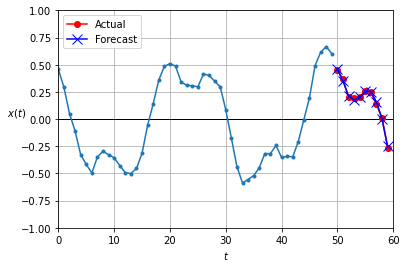

In [55]:
np.random.seed(42)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [56]:
keras.backend.clear_session()

In [57]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss = 'mse', optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train , epochs = 20, validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 32s 148ms/step - loss: 0.1002 - last_time_step_mse: 0.0519 - val_loss: 0.0299 - val_last_time_step_mse: 0.0322
Epoch 2/20
219/219 [==============================] - 32s 145ms/step - loss: 0.0226 - last_time_step_mse: 0.0170 - val_loss: 0.0194 - val_last_time_step_mse: 0.0136
Epoch 3/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0174 - last_time_step_mse: 0.0178 - val_loss: 0.0145 - val_last_time_step_mse: 0.0227
Epoch 4/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0100 - last_time_step_mse: 0.0224 - val_loss: 0.0059 - val_last_time_step_mse: 0.0166
Epoch 5/20
219/219 [==============================] - 32s 146ms/step - loss: 0.0040 - last_time_step_mse: 0.0093 - val_loss: 0.0035 - val_last_time_step_mse: 0.0058
Epoch 6/20
219/219 [==============================] - 32s 147ms/step - loss: 0.0023 - last_time_step_mse: 0.0027 - val_loss: 0.0020 - val_last_time_step_mse: 0.0016
Epoch 7/20

## GRU CELLS 
Gated Recurrent Unit (GRU) cell

In [58]:
keras.backend.clear_session()

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0813 - last_time_step_mse: 0.0442 - val_loss: 0.0198 - val_last_time_step_mse: 0.0204
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0170 - last_time_step_mse: 0.0167 - val_loss: 0.0115 - val_last_time_step_mse: 0.0124
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0055 - last_time_step_mse: 0.0075 - val_loss: 0.0029 - val_last_time_step_mse: 0.0054
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0022 - last_time_step_mse: 0.0060 - val_loss: 0.0015 - val_last_time_step_mse: 0.0057
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - last_time_step_mse: 0.0038 - val_loss: 8.5433e-04 - val_last_time_step_mse: 0.0022
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 7.5435e-04 - last_time_step_mse: 0.0013 - val_loss: 6.8710e-04 - val_last_time_step_mse: 8.1520e-04
Epoch 7/20


In [60]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 4.6970e-04 - last_time_step_mse: 1.2115e-04


[0.0004697019758168608, 0.00012114915443817154]

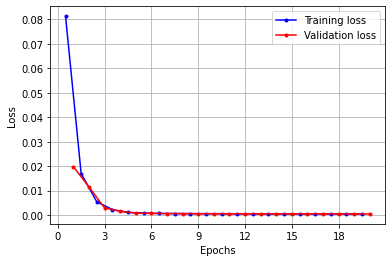

In [61]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [62]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

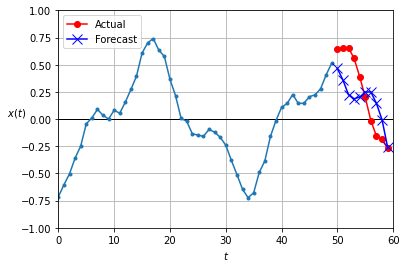

In [63]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## USING 1D CONVOLUTIONAL LAYERS TO PROCESS SEQUENCES

In [64]:
keras.backend.clear_session()

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0773 - last_time_step_mse: 0.0337 - val_loss: 0.0205 - val_last_time_step_mse: 0.0123
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0140 - last_time_step_mse: 0.0110 - val_loss: 0.0031 - val_last_time_step_mse: 0.0035
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0012 - last_time_step_mse: 0.0014 - val_loss: 5.7122e-04 - val_last_time_step_mse: 4.5013e-04
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 4.4066e-04 - last_time_step_mse: 3.8253e-04 - val_loss: 3.7105e-04 - val_last_time_step_mse: 4.8130e-04
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 3.0242e-04 - last_time_step_mse: 3.2176e-04 - val_loss: 2.7985e-04 - val_last_time_step_mse: 3.9229e-04
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 2.3301e-04 - last_time_step_mse: 2.6723e-04 - val_loss: 2.1134e-04 - val_las

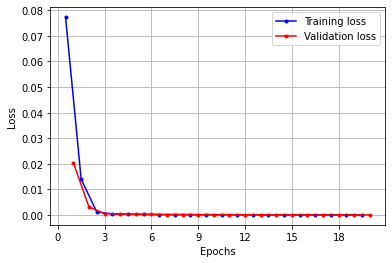

In [68]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## WaveNet

In [69]:
keras.backend.clear_session()

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0865 - last_time_step_mse: 0.0806 - val_loss: 0.0630 - val_last_time_step_mse: 0.0847
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0605 - last_time_step_mse: 0.0856 - val_loss: 0.0593 - val_last_time_step_mse: 0.0855
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0590 - last_time_step_mse: 0.0854 - val_loss: 0.0588 - val_last_time_step_mse: 0.0866
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0586 - last_time_step_mse: 0.0852 - val_loss: 0.0585 - val_last_time_step_mse: 0.0850
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0585 - last_time_step_mse: 0.0853 - val_loss: 0.0583 - val_last_time_step_mse: 0.0847
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0583 - last_time_step_mse: 0.0854 - val_loss: 0.0583 - val_last_time_step_mse: 0.0851
Epoch 7/20
219/219 [========

In [71]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0579 - last_time_step_mse: 0.0834


[0.057884469628334045, 0.0834352970123291]

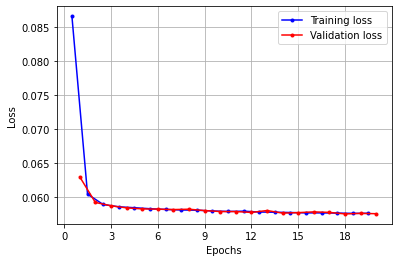

In [72]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [73]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [74]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [80]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1572 - last_time_step_mse: 0.0516 - val_loss: 0.1561 - val_last_time_step_mse: 0.0540
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1557 - last_time_step_mse: 0.0538 - val_loss: 0.1555 - val_last_time_step_mse: 0.0539
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1554 - last_time_step_mse: 0.0534 - val_loss: 0.1553 - val_last_time_step_mse: 0.0537
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1552 - last_time_step_mse: 0.0532 - val_loss: 0.1551 - val_last_time_step_mse: 0.0534
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1551 - last_time_step_mse: 0.0529 - val_loss: 0.1551 - val_last_time_step_mse: 0.0528
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1551 - last_time_step_mse: 0.0528 - val_loss: 0.1551 - val_last_time_step_mse: 0.0535
Epoch 7/20
219/219 [========

In [81]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.1550 - last_time_step_mse: 0.0529


[0.15499015152454376, 0.05293254181742668]

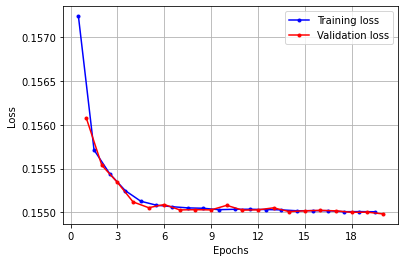

In [82]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()